# 触媒データ

Pymatgenを使った記述子算出と<br>
網羅的なモデル学習を行う

記述子として元々のデータに含まれていたセット`ORIGINAL`と<br> 
それらに元素ごとの物性値を存在比で重み付けしたセット`VARIABLE`を使う。<br>
予測モデルにはPLSとランダムフォレストを使用し、<br>
3変数をまとめて予測する多変量予測モデルを作る。

### Pymatgenを使った記述子計算

In [1]:
from pandas import read_csv
from pymatgen.core.periodic_table import Element, Specie
from pandas import DataFrame

In [3]:
df = read_csv('../data/catalyst/journal_data.csv',index_col=0)
df.head(3)

,Ag,K,Mo,W,Re,Au,Cl,Mg,Fe,Temp,...,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
label,,,,,,,,,,,,,,,,,,,,,
1,40,2.0,0.0,4.7,0.0,0.0,0.0,0.0,0.0,258,...,5.0,0.02,0.005,10.0,0,0,0,12.0,48.0,5.8
2,40,2.0,0.0,4.7,0.0,0.0,0.0,0.0,0.0,258,...,5.0,0.02,0.005,5.0,0,0,0,13.0,44.0,5.7
3,50,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,260,...,5.0,0.02,0.005,0.0,0,0,1,13.0,44.0,5.7


In [4]:
list_methods=["mendeleev_no", "electrical_resistivity",
                    "velocity_of_sound", "reflectivity",
                    "refractive_index", "poissons_ratio", "molar_volume",
                    "electronic_structure", "thermal_conductivity",
                    "boiling_point", "melting_point",
                    "critical_temperature", "superconduction_temperature",
                    "liquid_range", "bulk_modulus", "youngs_modulus",
                    "brinell_hardness", "rigidity_modulus",
                    "mineral_hardness", "vickers_hardness",
                    "density_of_solid", "atomic_radius_calculated",
                    "van_der_waals_radius", "atomic_orbitals",
                    "coefficient_of_linear_thermal_expansion",
                    "ground_state_term_symbol", "valence"]
elem_names = [e for e in dir(Element) if not e.startswith('_')]
print(len(elem_names))

103


In [5]:
dictionary = []
elements = []
for name in elem_names:
    elem = Element(name)
    if elem is not None:
        dictionary.append(elem.atomic_orbitals)
        elements.append(name)
    else:
        pass
df_orbits = DataFrame([c if c is not None else {} for c in dictionary],index=elem_names).fillna(0.)
print(len(dictionary), df_orbits.shape)
df_orbits.head(5)

103 (103, 18)


,1s,2p,2s,3d,3p,3s,4d,4f,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
Ac,-3443.110367,-572.762700,-592.622878,-119.541743,-137.654394,-147.320716,-23.570610,-12.278225,-31.761846,-36.15826,-3.222752,-6.06511,-7.713078,-0.137786,-0.744524,-1.19698,-0.126551,0.0
Ag,-900.324578,-120.913351,-129.859807,-13.367803,-20.067630,-23.678437,-0.298706,0.000000,-2.086602,-3.22309,0.000000,0.00000,-0.157407,0.000000,0.000000,0.00000,0.000000,0.0
Al,-55.156044,-2.564018,-3.934827,0.000000,-0.102545,-0.286883,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
Am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
Ar,-113.800134,-8.443439,-10.794172,0.000000,-0.382330,-0.883384,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0


In [6]:
tuple_vars = {'boiling_point', 'melting_point', 'density_of_solid', 'liquid_range', 'mendeleev_no', 'molar_volume', 'thermal_conductivity'} 
print(len(list(tuple_vars)))
tuple_vars = {'boiling_point', 'melting_point',                     'liquid_range', 'mendeleev_no', 'molar_volume', 'thermal_conductivity'}
print(len(list(tuple_vars)))

7
6


In [7]:
# tuple_vars, elements
w = lambda x,y: list(map(x, y))
X = w(lambda elem: w(lambda method: getattr(Element(elem), method), list(tuple_vars)), elements)

In [8]:
elements_indesc = [c_ for c_ in df.columns if c_ in elements]

In [9]:

w = lambda x,y: list(map(x, y))
X = w(lambda elem: w(lambda method: getattr(Element(elem), method), list(tuple_vars)), elements_indesc)

df_X = DataFrame(X,columns=tuple_vars,index=elements_indesc)
df_X

,liquid_range,mendeleev_no,boiling_point,thermal_conductivity,molar_volume,melting_point
Ag,1200.07,71.0,2435.00,430.0000,10.27,1234.93
K,695.47,10.0,1032.00,100.0000,45.94,336.53
Mo,2016.00,56.0,4912.00,139.0000,9.38,2896.00
W,2133.00,55.0,5828.00,170.0000,9.47,3695.00
Re,2410.00,58.0,5869.00,48.0000,8.86,3459.00
Au,1791.67,70.0,3129.00,320.0000,10.21,1337.33
Cl,67.51,99.0,239.11,0.0089,17.39,171.60
Mg,440.00,73.0,1363.00,160.0000,14.00,923.00
Fe,1323.00,61.0,3134.00,80.0000,7.09,1811.00
P,232.70,90.0,550.00,0.2360,17.02,317.30


**元素の物性値を使った記述子の算出**

以下の要領で存在比$C$と元素の物性値$X_{\rm pure}$から <br>
記述子を計算する。

```python 
C @ Xpure
``` 

**ORIGINAL記述子セット**<br>
元々の触媒の記述子$X_{\rm mix}$を使う

**VARIABLE記述子セット**<br>
元々の触媒の記述子$X_{\rm mix}$に$CX_{\rm pure}$を追加した<br>
$[X_{\rm mix},~CX_{\rm pure}]$を利用する<br>
（行列を横に結合している）。


In [10]:
from pandas import concat, merge
X_combi = concat((df_X, df_orbits), axis=1)
Xpure = X_combi.loc[X_combi.isna().sum(axis=1)==0,]

c:\users\shojiro_shibayama\miniconda3\envs\regz\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [11]:
from numpy import sort
df_X = df_X.reindex(sort(Xpure.index))

In [12]:
print(sort(Xpure.index))
Xpure.index

['Ag' 'Au' 'Cl' 'Fe' 'K' 'Mg' 'Mo' 'P' 'Re' 'W']


Index(['Ag', 'Au', 'Cl', 'Fe', 'K', 'Mg', 'Mo', 'P', 'Re', 'W'], dtype='object')

In [13]:
Xpure_desc = concat((df_X, Xpure), axis=1) 

In [14]:
Xmix = df[Xpure_desc.index]@ Xpure_desc

In [15]:
Xcalc = concat((Xmix,df), axis=1)

In [16]:
# TARGET = df.columns[-3:].tolist()
TARGET = ['Conv', 'Sel', 'Yield']

In [17]:
VARIABLE = Xmix.columns.tolist() + df.columns[:-3].tolist()
ORIGINAL = df.columns[:-3].tolist()

In [18]:
from sklearn.cross_decomposition import PLSRegression 
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [19]:
from warnings import filterwarnings
filterwarnings('ignore')
from numpy import arange, linspace

In [20]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
train_data, test_data = train_test_split(Xcalc, test_size=.33, random_state=66)
print(train_data.shape[0], test_data.shape[0])

50 25


In [26]:
n_folds = 5
for model_name, base in zip(['pls', 'rf' ], [PLSRegression(), RandomForestRegressor()]):
    for desc_name, vars in zip(['variable', 'original'], [VARIABLE, ORIGINAL]):
        Xtrain = train_data[vars]
        ytrain = train_data[TARGET]
        Xtest = test_data[vars]
        ytest = test_data[TARGET]
        
        if model_name == 'pls':
            pipe = make_pipeline(StandardScaler(), base)
            params={'plsregression__n_components': arange(1,11)}
            model = GridSearchCV(pipe, params, cv=n_folds)
        elif model_name == 'rf': 
            pipe=base
            model = RandomizedSearchCV(pipe, random_grid, n_iter=100, cv=n_folds, verbose=2, random_state=42, n_jobs = -1)
        model.fit(Xtrain, ytrain)
        print(model_name, desc_name,'CV_all: %.3f '%model.best_score_)
        for g_name, Xs, yo in zip(['train','test'], [Xtrain, Xtest], [ytrain, ytest]):
            yp = model.predict(Xs)
            print(g_name, end=' ')
            for i_comp in range(len(TARGET)):
                print(TARGET[i_comp]+' %.3f'%r2_score(yo.iloc[:,i_comp], yp[:,i_comp]), 
                      end=' ')
        print()

pls variable CV_all: 0.460 
train Conv 0.693 Sel 0.745 Yield 0.589 test Conv 0.575 Sel 0.636 Yield 0.234 
pls original CV_all: 0.398 
train Conv 0.640 Sel 0.689 Yield 0.552 test Conv 0.489 Sel 0.501 Yield 0.255 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


rf variable CV_all: 0.695 
train Conv 0.952 Sel 0.964 Yield 0.927 test Conv 0.828 Sel 0.793 Yield 0.700 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.0min finished


rf original CV_all: 0.702 
train Conv 0.951 Sel 0.963 Yield 0.923 test Conv 0.832 Sel 0.794 Yield 0.676 


In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [48]:
mpl.rcParams['font.size'] = 20 
mpl.rcParams['font.family'] = 'MS Gothic'
mpl.rcParams['figure.figsize'] = [10, 8]

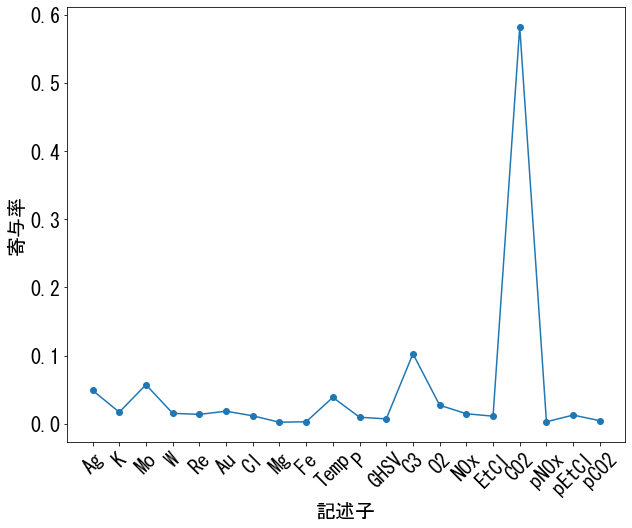

In [52]:

fig, ax= plt.subplots()
ax.plot(model.best_estimator_.feature_importances_, '-o')
plt.xticks(range(len(ORIGINAL)))
ax.set_xticklabels(ORIGINAL, rotation=45)
plt.xlabel('記述子')
plt.ylabel('寄与率')
plt.show()

## 考察の例

- `ORIGINAL`と`VARIABLE`の記述子セットを利用しても精度に差は見られなかった
- PLSとランダムフォレストではランダムフォレストの方が予測精度が高かった
  - すなわち、目的変数と説明変数の間には非線形性が成り立つ
- [元となる論文](https://www.jstage.jst.go.jp/article/jcac/7/0/7_0_69/_article/-char/ja/)
   ではPLSと変数選択を組み合わせたGAPLSを用いた解析を行っていたが、精度は低かった
- ランダムフォレストにおいて記述子寄与率を確認すると$CO_2$濃度が重要な変数であることが分かった